In [1]:
from ase import Atoms, io
import os

from attr import field
from conf_solv.trainer import LitConfSolvModule
from conf_solv.dataloaders.loader import create_pairdata
from joblib import Parallel, delayed
from rdkit import Chem
from rdkit.Chem import AllChem
from ase import Atoms, io

import yaml
import pickle
import numpy as np

from tqdm import tqdm

import torch
import torch_geometric as tg
from torch_geometric.data import Batch

from conf_solv.dataloaders.features import MolGraph
from conf_solv.model.model import ConfSolv

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed, IntSlider
import ipywidgets
from copy import deepcopy
import sys

In [3]:
def divide_solute_mols(solute_mols, n_anchor_mols=10, n_threshold_mols=50):

    anchor_mols = solute_mols[:n_anchor_mols]
    other_mols = solute_mols[n_anchor_mols:]
    n_chunks = int(np.ceil(len(other_mols) / (n_threshold_mols - n_anchor_mols)))
    batch_ids = [(i*(n_threshold_mols - n_anchor_mols), (i+1)*(n_threshold_mols - n_anchor_mols)) for i in range(n_chunks)]
    batch_solute_mols = [anchor_mols + other_mols[a:b] for (a,b) in batch_ids]
    
    return batch_solute_mols

In [4]:
def ase_atoms_from_xyz(xyz_path):
    ase_atoms_from_xyz = io.read(xyz_path,index=':')
    return ase_atoms_from_xyz

In [5]:
def flatten(xss):
    return [x for xs in xss for x in xs]

In [7]:
def load_lightning_model(trained_model_dir,i):
    models = [LitConfSolvModule.load_from_checkpoint(os.path.join(trained_model_dir, f'ensemble_{i}','best_model.ckpt'))]
    return models

def load_lightning_model_parallel(trained_model_dir,ensemble_nos):
    models = Parallel(n_jobs=-1)(delayed(load_lightning_model)(j,i) for j,i in zip(trained_model_dir,ensemble_nos))
    models = flatten(models)
    return models

In [8]:
filedir = os.path.abspath('')
print(filedir)
all_solute_mols = ase_atoms_from_xyz(os.path.join(filedir, 'Sorbitol.xyz'))
train_model_dir = os.path.join(filedir, 'trained_model')
#models = load_lightning_model(train_model_dir,0)
models = load_lightning_model_parallel([train_model_dir,train_model_dir],[0,1])

/home/gridsan/amenon


In [9]:
# change solvent_smi for predictions in a different solvent
solvent_smi = 'O'
solvent_molgraph = MolGraph(solvent_smi)

n_threshold_mols = 50  # change this based on available memory
n_anchor_mols = 0

In [11]:
#batch solute mols
# split input into [n_anchor_mols + (n_threshold_mols-n_anchor_mols)] sections
# should only trigger when n_solute_mols > n_threshold_mols
# ideally, n_threshold_mols is as large as possible
if len(all_solute_mols) > n_threshold_mols:
    batch_solute_mols = divide_solute_mols(all_solute_mols,
                                           n_anchor_mols=n_anchor_mols,
                                           n_threshold_mols=n_threshold_mols)
else:
    batch_solute_mols = [all_solute_mols]
print(batch_solute_mols[0][0])
n_atoms = batch_solute_mols[0][0].get_global_number_of_atoms()
  
out_final = torch.tensor([])
for batch_idx, solute_mols in enumerate(batch_solute_mols):
    data = create_pairdata(solvent_molgraph, solute_mols, len(solute_mols))
    data.solute_confs_batch = torch.concat([torch.zeros([n_atoms],dtype=torch.int64) + i for i in range( len(solute_mols))])
    batch_data = Batch.from_data_list([data], follow_batch=['x_solvent', 'x_solute'])

    out = torch.stack([model(batch_data,len(solute_mols)) for model in models])
    out_final = torch.cat([out_final, out], dim=-1)


out_scaled = out_final - out_final.min(dim=1, keepdim=True).values #Scale each prediction relative to lowest energy conformer.\n",
stds = out_scaled.std(dim=0)
preds = out_scaled.mean(dim=0)
preds = preds - preds.min()
print(preds*0.238846)
print(stds*0.238846)

Atoms(symbols='C2HCHCHCHCO6H10', pbc=False)
tensor([ 0.3961,  1.5076,  0.9889,  0.0000,  3.3721,  0.3083,  0.5833,  0.2262,
         1.7876,  2.6018,  1.3545,  1.1030,  4.9470,  3.8986,  5.6107,  1.8101,
         2.5145,  1.3079,  1.9797,  1.8967,  4.1142,  1.9050,  1.2115,  2.0143,
         2.4922,  2.8834,  2.2103,  4.2980,  3.7912,  6.9620,  2.7191,  2.1850,
         2.7436,  4.8396,  4.2468,  2.3919,  4.7684,  3.3649,  3.5369,  2.0248,
         5.8340,  5.3886,  7.2133,  3.6751,  7.1087,  5.0277,  4.4036,  6.0227,
         3.6257,  4.1019,  4.1506,  4.4505,  6.8924,  6.1241,  3.1425,  6.1455,
         4.6440,  6.4665,  6.3492,  6.5471,  3.3407,  6.7249,  6.1889,  7.2840,
         2.8383,  5.7351,  7.6066,  9.0058,  6.6597,  6.0471,  9.2460,  7.5948,
         5.4297, 10.4291,  5.3824,  3.6197,  1.2291,  3.0416,  2.7652,  2.6863,
         3.0006,  4.6168,  3.3285,  0.9681,  3.6667,  2.0567,  3.7257,  2.9936,
         1.9793,  1.7227,  1.9129,  2.1252,  2.0297,  3.0101,  2.5509,  2.98

In [26]:
m = Chem.MolFromSmiles('[O-]C(=C)[N+]1n[N]cc1C')

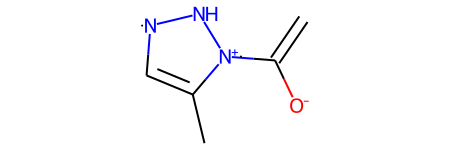

In [27]:
m